In [ ]:
!pip install wget
!pip install nudenet

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=2fb49731917f78ec3246b3ea4d75535ccea72da65a897cfea02c5f2d0856e38c
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 47.6 MB 78 kB/s 
     |████████████████████████████████| 4.8 MB 38.5 MB/s 


In [ ]:
# import os
# os.chdir('/content/drive/MyDrive/NLP_course/task_4')

In [ ]:
# os.path.isdir('/content/drive/MyDrive/NLP_course/task_4')

True

In [ ]:
# !rm -rf task_4

In [ ]:
# !cp -r /content/drive/MyDrive/NLP_course/task_4/blacklist_domains .

In [ ]:
import collections
import glob
import gzip
import json
import os
import re
import uuid
import csv
import shutil
import random
from PIL import Image
from bs4 import BeautifulSoup
import wget
from nudenet import NudeClassifier
nsfw_classifier = NudeClassifier()

MB100% (80.0 of 80.0) |##################| Elapsed Time: 0:00:01 Time:  0:00:01


Succefully Downloaded to: /root/.NudeNet/classifier_model.onnx


In [ ]:

URL_BLACKLIST = set()
HEADER = ["uuid", "image_url", "local_path", "alt_text", "context", "url", "segment", "warc_file"]
PATHS_FILE = "https://commoncrawl.s3.amazonaws.com/crawl-data/CC-MAIN-2021-31/warc.paths.gz"
DOWNLOAD_PREFIX = "https://commoncrawl.s3.amazonaws.com/"

BLACKLIST_FOLDER = "blacklist_domains"
#  Fill back_list urls
BLACKLIST_FILES = os.listdir(BLACKLIST_FOLDER)
for domains_list in BLACKLIST_FILES:
    if not os.path.isfile(os.path.join(BLACKLIST_FOLDER, domains_list)) or \
            not domains_list.endswith('.txt'): continue
    with open(os.path.join(BLACKLIST_FOLDER, domains_list), 'r') as fd:
        lines = fd.readlines()
        for line in lines:
            URL_BLACKLIST.add(line.rstrip())

def process_html(url, content, directory_data = None):
    """Processes single html webpage and extracts instructions as tasks."""

    domain = url.split('://')[1].split('/')[0]
    soup = BeautifulSoup(content, 'html.parser')
    returnme = list()
    # Remove unnecessary tags which could exist in <ol>
    for s in soup.select('script'):
        s.extract()
    for s in soup.select('noscript'):
        s.extract()
    for s in soup.select('table'):
        s.extract()
    for s in soup.select('figure'):
        s.extract()

    if domain == 'www.lifewire.com':
        for s in soup.find_all('div', {'class': 'theme-experttiptip'}):
            s.extract()
        for s in soup.find_all('div', {'class': 'theme-experttipimportant'}):
            s.extract()

    # For specific websites, need fine tune the parser to remove (.extract()) some
    # unnecessary tags to clean up the result got from ol.get_text()
    # if domain == 'www.wikihow.com':
    #     for s in soup.select('span'):
    #         s.extract()

    ols = soup.find_all('ol')

    for _, ol in enumerate(ols):

        if ol.find_all('img'):
            spans_in_image = ol.get_text(' ', strip=True).split("\n")
            # Only take in context texts which are more than 10 words (change later to higher number if required).
            segment, warc_file_name, directory_prefix = "", "", ""
            if directory_data:
                directory_prefix, segment, warc_file_name = directory_data
            for image_tag in ol.find_all('img'):
                if image_tag['alt'] != "":
                    try:
                        image_url = image_tag["src"]
                        
                        # check if the image is hosted on web.
                        if not image_url.startswith("http"):
                            image_url = image_tag.get("longdesc")
                            if not image_url.startswith("http"):
                                continue
                        # Duplicate file already downloaded. (Like some thread where user profile pops in all the
                        # conversations we will not miss the context as we taken dump of all the spans for the first
                        # image.
                        if os.path.isfile(os.path.join(directory_prefix, image_url.split('/')[-1])):
                            continue
                        image_filename = image_url.split('/')[-1]
                        if not (image_filename.lower().endswith('.jpeg') or
                                image_filename.lower().endswith('.png') or
                                image_filename.lower().endswith('.jpg')):
                            continue
                        image_filename = wget.download(image_url, out=directory_prefix)

                        if ('.gif' in image_filename.lower()):
                            os.remove(image_filename)
                            continue
                        
                        # Add context filtering here.
                        # Check the context of the image and filter spans_in_image if the filter causes spans_in_image
                        # to be empty then continue to next image.

                        # Image filtering
                        with Image.open(image_filename) as im:
                            w, h = im.size
                            if w < 400 or h < 400:
                                os.remove(image_filename)
                                continue
    
                        # Remove NSFW pictures
                        scores = nsfw_classifier.classify(image_filename)
                        if scores[image_filename]['safe'] < 0.4:
                            continue
                        
                        alt_text = image_tag['alt']
                        # Check if it's english
                        # If caption is less than 15 characters skip.
                        # At least 15 words of context paragraph.
                        context = spans_in_image[0] + ','.join(spans_in_image[1:])
                        my_uuid = str(uuid.uuid4())
                        web_url = url
                        warc_segment = segment
                        warc_fn = warc_file_name
                        write_list = [my_uuid, image_url, image_filename, alt_text, context, web_url, warc_segment, warc_fn]
                        returnme.append(write_list)
                    except Exception as e:
                        os.remove(image_filename)
                        continue

    return returnme

def _is_valid(url, inst):
    url_words = re.compile(r'\w+').findall(url.lower())
    instruction_words = re.compile(r'\w+').findall(inst.lower())

    phone_set = {'android', 'phone', 'iphone'}
    click_set = {'tap', 'click'}

    return (set(url_words + instruction_words).intersection(phone_set) and
            set(instruction_words).intersection(click_set))

# DomainStatsIdx
COUNT_IN_WARC = 0
COUNT_IS_RESPONSE = 1
COUNT_HTML = 2
COUNT_HTML_HAS_INST = 3
COUNT_INST = 4

def _parse_one_page(lines, stats, domain_stats, download_data=None):
    """Parses one page in warc file.
  Args:
    lines: the lines of WARC content to parse, which should contain single web
      interaction info, such as a request or a response
    stats: dict of {string, int}, for reason of failure and count
    domain_stats: dict of {domain: [a, b, c, d, e]} which are the counts of
      different DomainStatsIdx items for each domain
  Returns:
    list of triple (url, instruction, html_content) for each instruction found.
  """
    if not lines:
        return []
    if lines[0].strip() != 'WARC/1.0':
        stats['Error_no_WARC/1.0_in_head'] += 1
        return []

    url = None
    warc_type = None
    section = 1
    html_lines = []
    for _, line in enumerate(lines):
        line = line.strip()
        if section < 3:
            if not line:
                section += 1
        if section == 1:
            if line.startswith('WARC-Type: '):
                warc_type = line[len('WARC-Type: '):].strip()
            if line.startswith('WARC-Target-URI: '):
                url = line[len('WARC-Target-URI: '):].strip()
                # Extract support.google.com from
                # https://support.google.com/news/publisher-center/answer/9603942
                domain = url.split('://')[1].split('/')[0]
                # Skip black listed domains
                # Includes 
                if domain in URL_BLACKLIST:
                    return []
                # skip blacklisted urls (NSFW)
                # if FLAGS.filter_domain:
                #     if domain not in URL_WHITE_LIST:
                #         stats['NotFound_Domain_mismatch'] += 1
                #         return []
                domain_stats['DOMAIN_' + domain][COUNT_IN_WARC] += 1
                if warc_type == 'response':
                    domain_stats['DOMAIN_' + domain][COUNT_IS_RESPONSE] += 1

        if section == 3 and line:  # section 3 is html:
            html_lines.append(line)
    if not url or not html_lines:
        stats['No_HTML'] += 1
        return []

    domain_stats['DOMAIN_' + domain][COUNT_HTML] += 1

    try:
        html_content = '\n'.join(html_lines)
        instructions = process_html(url, html_content, download_data)
    except Exception:  # pylint: disable=broad-except
        stats['Error_parse_html'] += 1
        return []

    if not instructions:
        stats['No_instruction'] += 1
        return []

    stats['Got'] += 1
    domain_stats['DOMAIN_' + domain][COUNT_HTML_HAS_INST] += 1
    domain_stats['DOMAIN_' + domain][COUNT_INST] += len(
        instructions)
    return instructions

def extract_instructions_from_warc_file(warc_file_path, file_handler, download_data=""):
    """Reads instruction from WARC file.
  Args:
    warc_file_path: warc file path.
    file_handler: file handler of the warc file.
  Yields:
    triple(url, index, instruction)
  """
    lines_of_one_page = []
    stats = collections.defaultdict(int)
    domain_stats = collections.defaultdict(lambda: [0, 0, 0, 0, 0])

    for line in file_handler:
        if line.strip().startswith('WARC/1.0'):
            stats['Total'] += 1
            urls_and_instructions = _parse_one_page(lines_of_one_page,
                                                    stats, domain_stats, download_data=download_data)
            for csv_row in urls_and_instructions:
                yield csv_row
            lines_of_one_page = [line]
        else:
            lines_of_one_page.append(line)

    urls_and_instructions = _parse_one_page(lines_of_one_page,
                                            stats, domain_stats, download_data=download_data)
    stats['file_name'] = warc_file_path

    # if FLAGS.filter_domain:  # without filter, the log will be too long
    #     logging.info(json.dumps({**stats, **domain_stats}))
    for csv_row in urls_and_instructions:
        yield csv_row


In [ ]:
def fill_csv_download_image():
    # This is for the downloaded WARC files if they are stored in local device.
    # If the downloaded WARC files are stored in your own remote file system,
    # please costomize this part.

    # segments = ['1627046152156.49', '1627046153531.10', '1627046153860.57', '1627046154032.75']
    segments = ['1627046154032.75']
    warc_file = wget.download(PATHS_FILE)
    with gzip.open(warc_file, 'rb') as f_in:
        # Ignore .gz extention
        with open(warc_file[:-3], 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    segment_dict = collections.defaultdict(list)
    with open(warc_file[:-3], 'r') as warc_paths:
        for warc_line in warc_paths.readlines():
            for segment in segments:
                if segment in warc_line.rstrip():
                    segment_dict[segment].append(warc_line.rstrip())
                    break

    os.remove(warc_file)
    os.remove(warc_file[:-3])

    # Taking 2 from each segment
    for segment_k in segment_dict:
        segment_dict[segment_k] = random.sample(segment_dict[segment_k], 4)

    csv_file_descriptor = open("dataset4_task.csv", 'a', newline='')
    csv_writer = csv.writer(csv_file_descriptor)
    csv_writer.writerow(HEADER)
    try:
        for segment in segment_dict:
            for warc_file_download_link in segment_dict[segment]:
                warc_file = wget.download(DOWNLOAD_PREFIX + warc_file_download_link)
                download_dir = segment + "_" + warc_file.split(".")[0].split("-")[-1]
                os.makedirs(download_dir)
                with open(warc_file, 'rb') as f1:
                    with gzip.open(f1, mode='rt', encoding='latin1') as f2:
                        for csv_row in extract_instructions_from_warc_file(warc_file, f2, download_data=(download_dir, segment, warc_file)):
                            csv_writer.writerow(csv_row)
                os.remove(warc_file)

    finally:
        csv_file_descriptor.close()


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
# os.chdir('/content/drive/MyDrive/NLP_course/task_4/')

In [ ]:
# We are downloading images locally as there was an issue with google colab,
# It got stuck randomly during a download.

In [ ]:
!pip install langdetect
!pip install -U sentence-transformers
!pip install pyyaml==5.1
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

     |████████████████████████████████| 981 kB 8.8 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=f76262a502870ca65cdffc9fcb04490bc41e381d7ad0c9273d97be42dc04a2ea
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
     |████████████████████████████████| 78 kB 4.6 MB/s 
     |████████████████████████████████| 2.9 MB 15.6 MB/s 
     |████████████████████████████████| 3.3 MB 55.7 MB/s 
     |████████████████████████████████| 1.2 MB 73.1 MB/s 
     |████████████████████████████████| 56 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 67.4 MB/s 
     |████████████████████████████████| 895 kB 73.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=83a77fccec9efbda647d30fa6268223723260598984b7753f5f0402510044c63
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84

In [ ]:
from langdetect import detect
import scipy
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def _replace_unicode_with_space(text):
    """Replaces all unwanted unicode chars with single space."""
    returnme = ''.join([i if ord(i) < 128 else ' ' for i in text])
    returnme = ' '.join(returnme.split())  # Change all space/newline to one space
    return returnme

In [ ]:
import sys
import csv

csv.field_size_limit(sys.maxsize)

131072

In [ ]:
os.listdir()

['blacklist_domains',
 'dataset4_task.csv',
 '1627046153860.57_00197',
 '1627046153860.57_00001',
 '1627046153531.10_00422',
 '1627046153531.10_00390',
 '1627046153531.10_00311',
 '1627046153531.10_00220',
 '1627046153531.10_00146',
 '1627046152156.49_00630',
 '1627046152156.49_00577',
 '1627046152156.49_00505',
 '1627046152156.49_00458',
 '1627046152156.49_00170',
 'filtered_dataset4_task.csv']

In [ ]:
# [my_uuid, image_url, image_filename, alt_text, context, web_url, warc_segment, warc_fn]
HEADER = ["uuid", "image_url", "local_path", "alt_text", "context", "url", "segment", "warc_file"]
import csv
filtered_csv_file_descriptor = open("filtered_dataset4_task.csv", 'w', newline='')
filtered_csv_writer = csv.writer(filtered_csv_file_descriptor)
filtered_csv_writer.writerow(HEADER)
count_non_english = 0

def fix_nulls(s):
    for line in s:
        yield line.replace('\0', '')

with open("dataset4_task.csv", 'r', newline='') as csv_file_descriptor:
    csv_reader = csv.reader(fix_nulls(csv_file_descriptor))
    next(csv_reader, None)  # skip the headers
    for [my_uuid, image_url, image_filename, alt_text, context, web_url, warc_segment, warc_fn] in csv_reader:
        # valid picture filtering, also removes .tmp or incomplete downloads
        if not os.path.exists(image_filename): continue
        if not (image_filename.lower().endswith('jpg') or 
                image_filename.lower().endswith('jpeg') or
                image_filename.lower().endswith('png')):
                os.remove(image_filename)
                continue

        alt_text = _replace_unicode_with_space(alt_text)
        context = _replace_unicode_with_space(context)
        try:
            detect(alt_text) != 'en'
            detect(context) != 'en'
            # We replaced all non unicode, just checkif the string is still valid.
            # Detect throws exception when the string is not a valid language.
            # follwing bert model supports more than 80 languages so no need to
            # ignore languages like france, spanish etc.
        except Exception:
            # No letters just symbols
            count_non_english += 1
            if count_non_english <= 10:
                print(f"NON ENGLISH OR EMPTY ALT_TEXT / CONTEXT \nALTTEXT: {alt_text}\nContext: {context}")
            os.remove(image_filename)
            continue
        
        # Nsfw image filtering is taken care by nude net already.
        # Filter context, in the dumped texts check for atmost 5 sentences which relate.
        context = [i for i in context.split('\n')]
        new_context = list()
        for i in context:
            if len(i.split(' ')) > 4:
                new_context.append(i)
        context = new_context
        if len(context) == 0:
            os.remove(image_filename)
            continue
        alt_emb = model.encode(alt_text)
        context_emb = model.encode(context)
        if not context_emb.any():
            continue
        dist = scipy.spatial.distance.cdist([alt_emb], context_emb, "cosine")
        results = zip(range(len(dist)), dist)
        results = sorted(results, key=lambda x: x[1])
        # Only have top 5 sentence
        new_context = [context[idx] for idx, dist in results[:5]]
        context = new_context[0] + '\n'.join(new_context[1:])
        
        filtered_csv_writer.writerow([my_uuid, image_url, image_filename, alt_text, context, web_url, warc_segment, warc_fn])
filtered_csv_file_descriptor.close()

print("________________________________________________________________________")
print(f"STATS: Non-english alt-text or context skipped: {count_non_english}")
print("________________________________________________________________________")

NON ENGLISH OR EMPTY ALT_TEXT / CONTEXT 
ALTTEXT: 450 (450 / )
Context: Fiio M6 Titanium Fiio M6 Titanium : M6 Titanium : Fiio FiiO FH5 titanium FiiO FH5 titanium : FH5 titanium : FiiO 450 (450 / ) 450 (450 / ) : 450 (450 / ) : GEOZON TITANIUM Blue GEOZON TITANIUM Blue : Titanium G-SM10BLKB : Geozon Soundcare SuperSpike SA Titanium ( 3 .) Soundcare SuperSpike SA Titanium ( 3 .) : SuperSpike SA Titanium ( 3 .) : Soundcare Gamma Piu Extra Pro XL LCD Titanium Gamma Piu Extra Pro XL LCD Titanium : Extra Pro XL LCD Titanium : Gamma Piu Ubiquiti Bullet M5 Titanium BM5-TI Ubiquiti Bullet M5 Titanium BM5-TI : Bullet M5 Titanium : Ubiquiti AfterShokz Trekz Titanium Ocean-Blue AS600OB AfterShokz Trekz Titanium Ocean-Blue AS600OB : Trekz Titanium : AfterShokz DFC World Cup DFC World Cup : World Cup : DFC 450 Diolex (DXMV-450-2) 450 Diolex (DXMV-450-2) : (DXMV-450-2) : Diolex Royal Cup 450ml BK-77 Royal Cup 450ml BK-77 : BK-77 : Royal Cup 0.4 Walmer Eco Cup (W24201801) 0.4 Walmer Eco Cup (W2420180

In [ ]:
import torch
torch.__version__

'1.9.0+cu111'

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [ ]:
# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
image_path_list = list()
my_display_images = [
'1627046152156.49_00577/1627236237_959426_1627240259_miniatura_normal.jpg',
'1627046152156.49_00170/must-try-food-and-drink-destinations-outside-the-gta.jpg',
'1627046152156.49_00458/107-2-1.jpg',
'1627046152156.49_00458/107-5-1.jpg',
'1627046152156.49_00458/107-2-5.jpg',
'1627046152156.49_00458/107-2-6.jpg',
'1627046152156.49_00577/30-0482-1-A_8.jpg',
'1627046152156.49_00577/wGR150_MODEL_WATER_ANGLE.jpg',
'1627046152156.49_00577/35765LF-PD_MODEL_02_WEB.jpg',
'1627046152156.49_00577/Interior-Design-KBIS-2020-Native_Trails_Positano_Shoreline_WEB_2000.jpg',
'1627046152156.49_00505/3441_white_limed_oak.jpg',
'1627046152156.49_00505/atlantic-slate_6.jpg',
'1627046152156.49_00505/Colonia_Wood_Nordic_White_Oak_4436_4.jpg',
'1627046152156.49_00505/3439_hickory_oak.jpg',
'1627046152156.49_00505/031669_675_01.jpg',
'1627046152156.49_00458/3xccj1ad0_911_f_1_4.jpg',
'1627046152156.49_00458/instinkt_huhn_napf_2.png',
'1627046152156.49_00458/KP_SA_16.jpg',
]
with open("filtered_dataset4_task.csv", 'r', newline='') as csv_file_descriptor:
    csv_reader = csv.reader(csv_file_descriptor)
    next(csv_reader, None)  # skip the headers
    for [my_uuid, image_url, image_filename, alt_text, context, web_url, warc_segment, warc_fn] in csv_reader:
        if image_filename in my_display_images:
            image_path_list.append((image_filename, alt_text, context))
        # Use selected images to sample the data
        # image_path_list.append((image_filename, alt_text, context))

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}




IMAGE PATH:  1627046152156.49_00458/107-2-5.jpg
ALT TEXT:  Arco de terra adicionado carne picada de carne
CONTEXT:  Tub rculos de batata purificados e completamente lavados em um ralador com c lulas m dias. Adicione suco de lim o ( necess rio para que as batatas n o seque). Atire em uma peneira, substituindo os recipientes profundos sob ele. Isso necess rio para remover a quantidade m xima de fluido de batatas. Enquanto isso, prepare o preenchimento de carne. Se a carne for usada - pique em um moedor de carne. Voc pode tomar qualquer - carne, carne de porco, peru, frango ou combin -las em propor es arbitr rias. Mince adicionar sal, especiarias, incluindo passado pelo alho de imprensa, bem como finamente picado ou interrompido em um liquidificador metade das l mpadas. Misture bem antes da viscosidade. Suco de batata alocado para mesclar, e amido, que cair no fundo da tigela, enviar de volta para a batata ralada. H um ovo e sal l . Misturar. Leve as m os de uma pequena massa de batata,

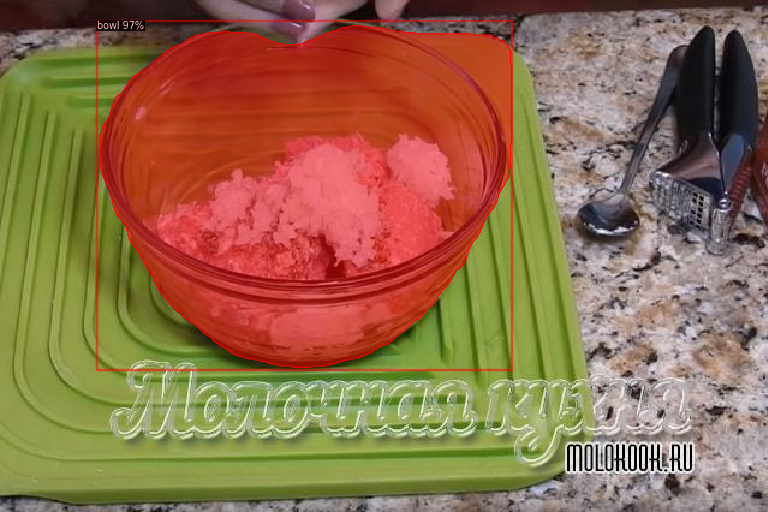

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}




IMAGE PATH:  1627046152156.49_00458/107-2-6.jpg
ALT TEXT:  Adicionando o Ovo de Frango
CONTEXT:  Tub rculos de batata purificados e completamente lavados em um ralador com c lulas m dias. Adicione suco de lim o ( necess rio para que as batatas n o seque). Atire em uma peneira, substituindo os recipientes profundos sob ele. Isso necess rio para remover a quantidade m xima de fluido de batatas. Enquanto isso, prepare o preenchimento de carne. Se a carne for usada - pique em um moedor de carne. Voc pode tomar qualquer - carne, carne de porco, peru, frango ou combin -las em propor es arbitr rias. Mince adicionar sal, especiarias, incluindo passado pelo alho de imprensa, bem como finamente picado ou interrompido em um liquidificador metade das l mpadas. Misture bem antes da viscosidade. Suco de batata alocado para mesclar, e amido, que cair no fundo da tigela, enviar de volta para a batata ralada. H um ovo e sal l . Misturar. Leve as m os de uma pequena massa de batata, distribua a palma 

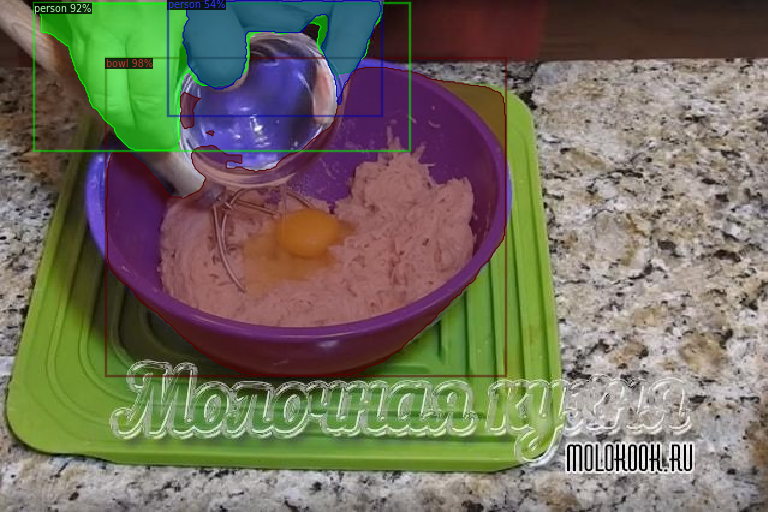

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}




IMAGE PATH:  1627046152156.49_00458/107-2-1.jpg
ALT TEXT:  Prepara es de Dankov.
CONTEXT:  Tub rculos de batata purificados e completamente lavados em um ralador com c lulas m dias. Adicione suco de lim o ( necess rio para que as batatas n o seque). Atire em uma peneira, substituindo os recipientes profundos sob ele. Isso necess rio para remover a quantidade m xima de fluido de batatas. Enquanto isso, prepare o preenchimento de carne. Se a carne for usada - pique em um moedor de carne. Voc pode tomar qualquer - carne, carne de porco, peru, frango ou combin -las em propor es arbitr rias. Mince adicionar sal, especiarias, incluindo passado pelo alho de imprensa, bem como finamente picado ou interrompido em um liquidificador metade das l mpadas. Misture bem antes da viscosidade. Suco de batata alocado para mesclar, e amido, que cair no fundo da tigela, enviar de volta para a batata ralada. H um ovo e sal l . Misturar. Leve as m os de uma pequena massa de batata, distribua a palma para s

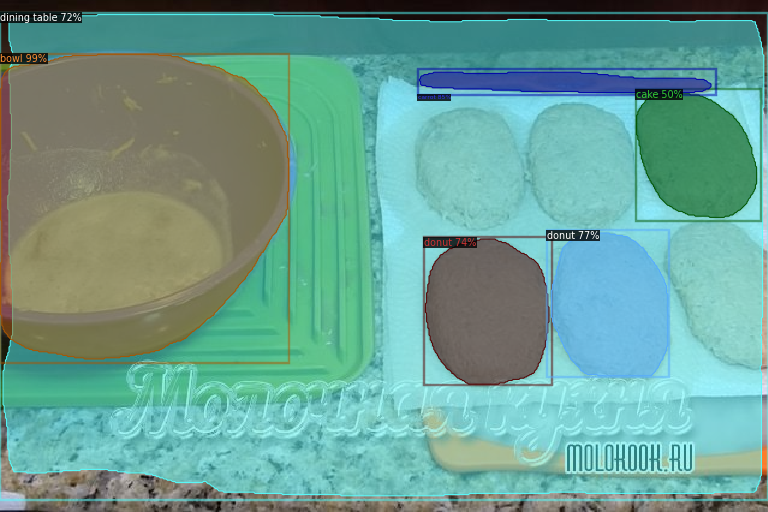

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}




IMAGE PATH:  1627046152156.49_00458/107-5-1.jpg
ALT TEXT:  Pur
CONTEXT:  Batatas para fumar em um pur homog neo. Se um pur ontem, ele precisa ser aquecido no microondas, adicionando uma pequena quantidade de gua ou leite. A consist ncia deve ser ar e concurso, sem peda os. Adicione aos batatas ovo, sal, farinha e pimenta. Misture bem. Segure o queijo em uma tigela. E misture novamente. A missa n o ser legal, os bolos n o v o funcionar com isso. Aque a o leo, coloque a painja na forma de espa os em branco arredondados. Isso pode ser feito com uma colher ou com uma bolsa de confeitaria. Corte panquecas de um lado em fogo m dio, transform -los com uma p e continue a fritar por mais alguns minutos.


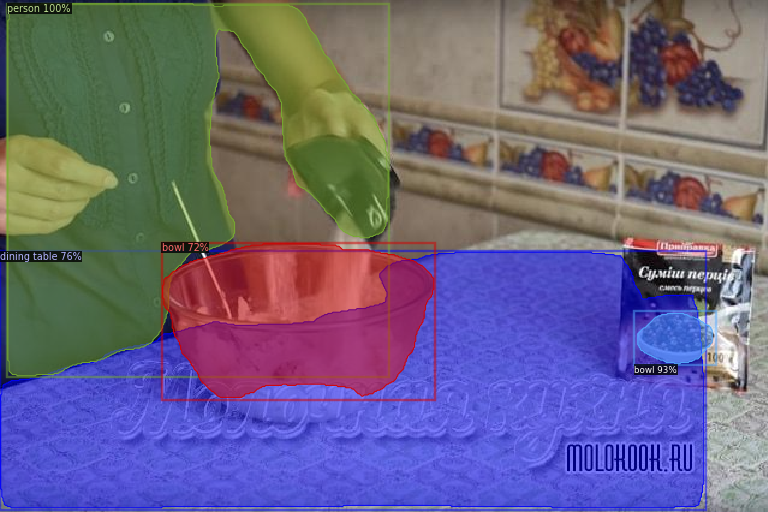

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}




IMAGE PATH:  1627046152156.49_00458/3xccj1ad0_911_f_1_4.jpg
ALT TEXT:  Playera a rayas con bolsillo
CONTEXT:  1 colores A adir a Lista de Deseos Playera a rayas con bolsillo $790.00 Comprar


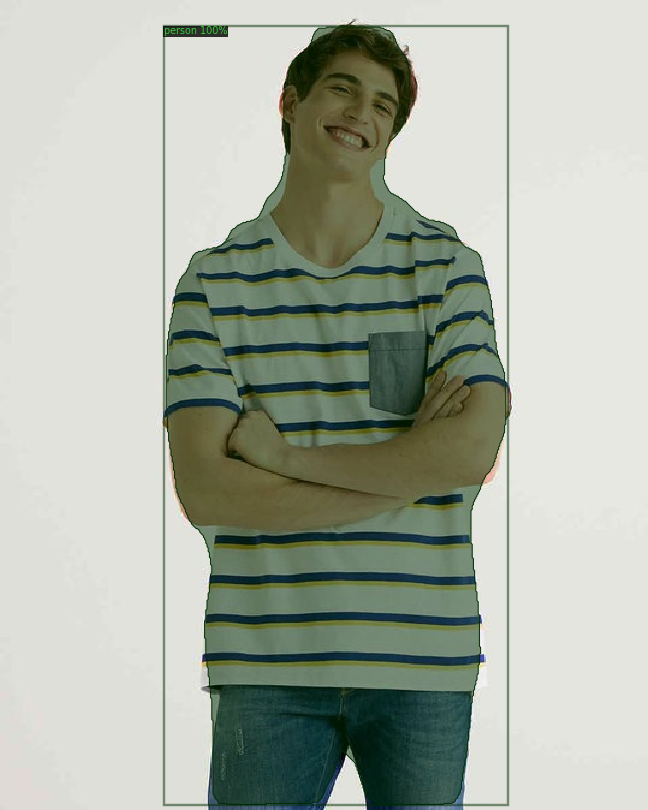

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}




IMAGE PATH:  1627046152156.49_00458/instinkt_huhn_napf_2.png
ALT TEXT:  INSTINKT Men Huhn 1000g
CONTEXT:  INSTINKT Men Huhn 1000g 4,89 ab: 4,59 inkl. MwSt. , zzgl. Versandkosten Ins K rbchen Auf die Vergleichsliste INSTINKT Men Rind 1000g 4,89 ab: 4,69 inkl. MwSt. , zzgl. Versandkosten Ins K rbchen Auf die Vergleichsliste Omega 3-6-9 BARF l 250ml 14,90 ( 5,96 / 100 Milliliter (ml)) inkl. MwSt. , zzgl. Versandkosten Ins K rbchen Auf die Vergleichsliste


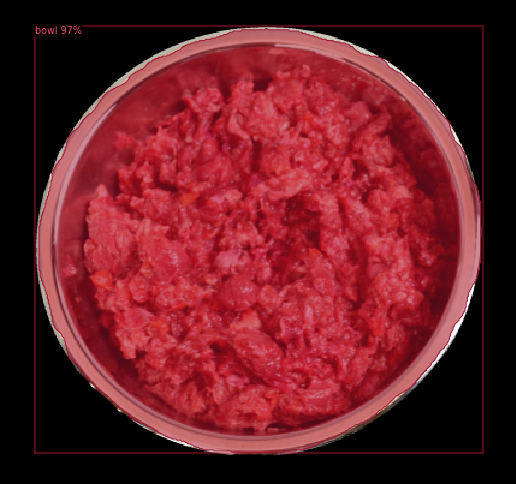

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}




IMAGE PATH:  1627046152156.49_00458/KP_SA_16.jpg
ALT TEXT:  Adah - Istina - Divlja rasa
CONTEXT:  KEN PARKER 536 bodova Adah - Istina - Divlja rasa KP SA 16 KP SA 20 | trajk - Donovanovi dje aci - Normin princ | 385 bodova MN BOP 44 | Vijetnam | 346 bodova DEAD ZSR 21 | Crno kao no , crveno kao krv | 293 bodova DRGN BZDN 1 | Bezdu ni | 284 bodova


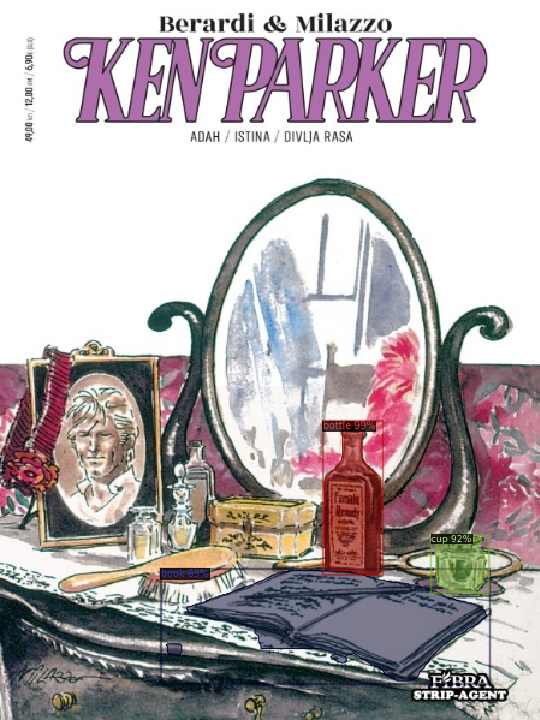

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}




IMAGE PATH:  1627046152156.49_00577/1627236237_959426_1627240259_miniatura_normal.jpg
ALT TEXT:  El COE asume un dilema pol mico para sustituir a Jon Rahm: Santi Tarr o reclama su sitio ante Jorge Campillo
CONTEXT:  Anticorrupci n pide prorrogar la investigaci n de la caja b del PP en Madrid El Gobierno aprobar ma ana la mayor oferta p blica de empleo de la historia con 30.445 plazas Elvira Lindo, sobre los an nimos que han recibido ella y su marido: "Te ponen la etiqueta y ya te odian" Juegos Ol mpicos de Tokio, en directo: David Valero consigue la medalla de bronce para Espa a en MBT El COE asume un dilema pol mico para sustituir a Jon Rahm: Santi Tarr o reclama su sitio ante Jorge Campillo


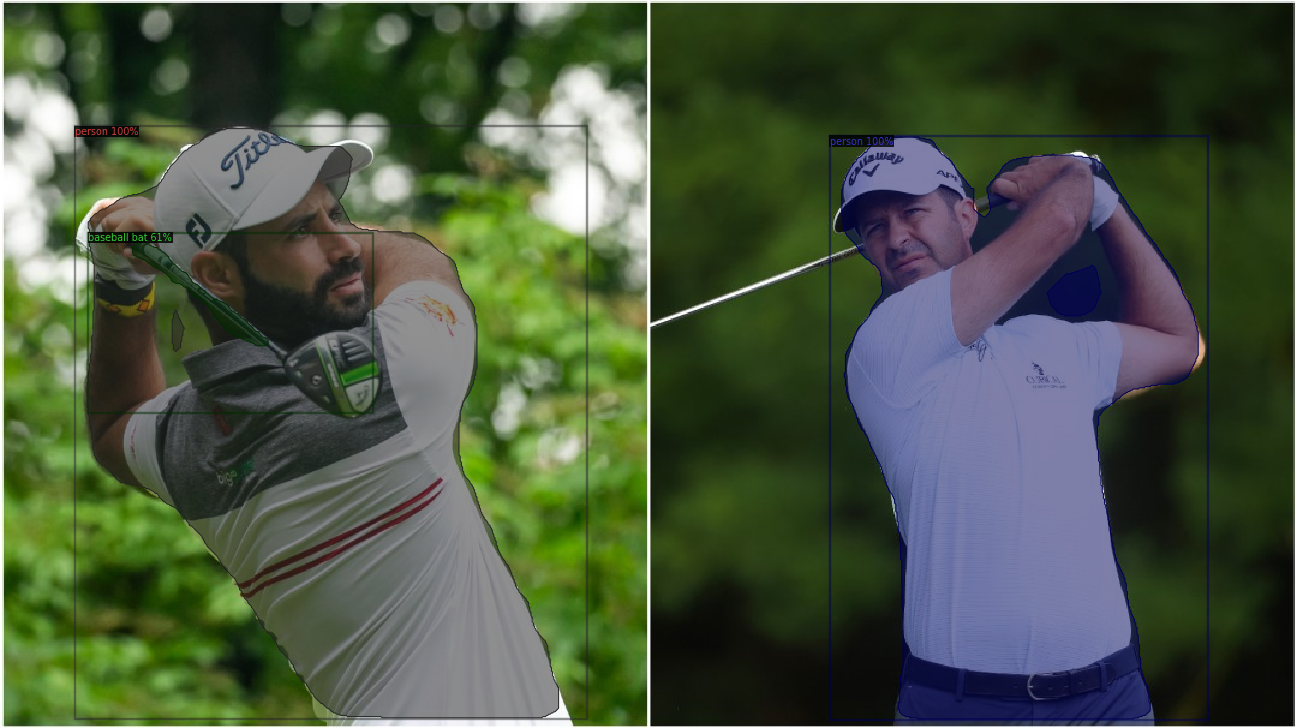

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}




IMAGE PATH:  1627046152156.49_00577/30-0482-1-A_8.jpg
ALT TEXT:  GIACOMO - Juego de herrajes para puertas correderas colgantes
CONTEXT:  NOVEDAD 1 variante MAGIC-2 FRAME Gu a invisible m s perfiles para puerta corredera de vidrio Desde 633,12 8 variantes GIACOMO - Juego de herrajes para puertas correderas colgantes Material: Aluminio Desde 31,04


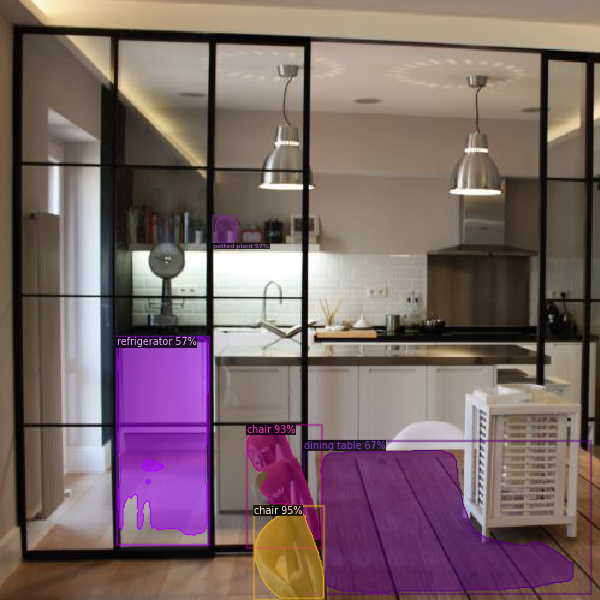

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}




IMAGE PATH:  1627046152156.49_00577/wGR150_MODEL_WATER_ANGLE.jpg
ALT TEXT:  wGR150_MODEL_WATER_ANGLE
CONTEXT:  Voice-Activated Faucets Ask you shall receive. Voice activated faucets will dispense warm or hot water or exactly the amount of water you need for your recipe. Two options that pair with Google or Alexa include Delta s VoiceIQ and Moen s U Faucet. Moen Glass Rinsers Ever seen a bartender or waiter quickly rinse the inside of a glass by pressing down on little device at the sink? Now you can have one of those at home! Delta is offering glass rinsers as an add-on for your kitchen, bar, or even bathroom sink. Delta Pull-Out Spray Faucets for the Bathroom Delta is the first brand making faucets with an integrated pull-out sprayer and we can't wait to try it in our bathrooms! Just think of how easy it will be to keep the sink clean. Delta Convertible Fridge Drawers Installed under your countertops, Signature Kitchen Suite's Convertible Drawers offer six settings from pantry to fr

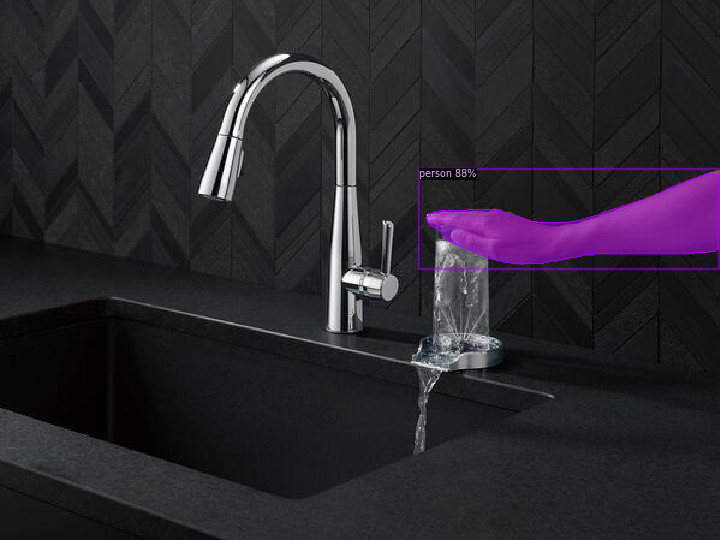

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}




IMAGE PATH:  1627046152156.49_00577/35765LF-PD_MODEL_02_WEB.jpg
ALT TEXT:  35765LF-PD_MODEL_02_WEB
CONTEXT:  Voice-Activated Faucets Ask you shall receive. Voice activated faucets will dispense warm or hot water or exactly the amount of water you need for your recipe. Two options that pair with Google or Alexa include Delta s VoiceIQ and Moen s U Faucet. Moen Glass Rinsers Ever seen a bartender or waiter quickly rinse the inside of a glass by pressing down on little device at the sink? Now you can have one of those at home! Delta is offering glass rinsers as an add-on for your kitchen, bar, or even bathroom sink. Delta Pull-Out Spray Faucets for the Bathroom Delta is the first brand making faucets with an integrated pull-out sprayer and we can't wait to try it in our bathrooms! Just think of how easy it will be to keep the sink clean. Delta Convertible Fridge Drawers Installed under your countertops, Signature Kitchen Suite's Convertible Drawers offer six settings from pantry to free

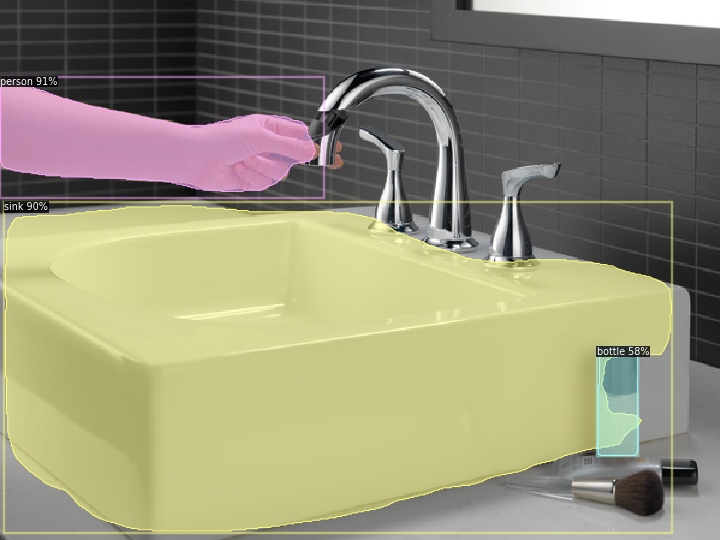

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}




IMAGE PATH:  1627046152156.49_00577/Interior-Design-KBIS-2020-Native_Trails_Positano_Shoreline_WEB_2000.jpg
ALT TEXT:  Interior-Design-KBIS-2020-Native_Trails_Positano_Shoreline_WEB_2000
CONTEXT:  Voice-Activated Faucets Ask you shall receive. Voice activated faucets will dispense warm or hot water or exactly the amount of water you need for your recipe. Two options that pair with Google or Alexa include Delta s VoiceIQ and Moen s U Faucet. Moen Glass Rinsers Ever seen a bartender or waiter quickly rinse the inside of a glass by pressing down on little device at the sink? Now you can have one of those at home! Delta is offering glass rinsers as an add-on for your kitchen, bar, or even bathroom sink. Delta Pull-Out Spray Faucets for the Bathroom Delta is the first brand making faucets with an integrated pull-out sprayer and we can't wait to try it in our bathrooms! Just think of how easy it will be to keep the sink clean. Delta Convertible Fridge Drawers Installed under your counterto

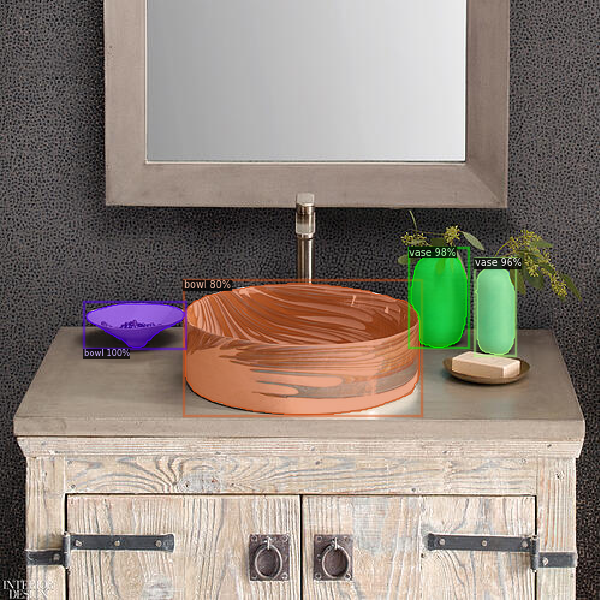

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}




IMAGE PATH:  1627046152156.49_00505/3441_white_limed_oak.jpg
ALT TEXT:  Polyflor Camaro Loc 3441 White Limed Oak Click Vinyl Flooring
CONTEXT:  Polyflor Camaro Loc 3427 Grey Mountain Ash Click Vinyl Flooring From 25.95 m 2 Includes VAT & Free Delivery As low as 46.54 Quantity Discount Available From 23.50 m 2 Add to Cart Compare Polyflor Camaro Loc 3437 Smoked Limed Oak Click Vinyl Flooring From 25.95 m 2 Includes VAT & Free Delivery As low as 45.59 Quantity Discount Available From 23.50 m 2 Add to Cart Compare Polyflor Camaro Loc 3441 White Limed Oak Click Vinyl Flooring From 25.95 m 2 Includes VAT & Free Delivery As low as 46.54 Quantity Discount Available From 23.50 m 2 Add to Cart Compare Polyflor Camaro 2233 Smoked Brushed Elm Luxury Vinyl Flooring From 18.95 m 2 Includes VAT & Free Delivery As low as 60.08 Quantity Discount Available From 17.99 m 2 Add to Cart Compare Polyflor Camaro 2229 White Limed Oak Luxury Vinyl Flooring From 18.95 m 2 Includes VAT & Free Delivery As low a

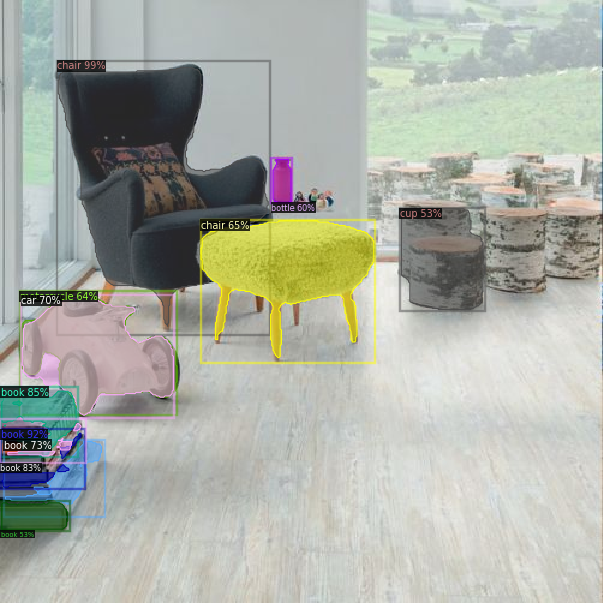

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}




IMAGE PATH:  1627046152156.49_00505/atlantic-slate_6.jpg
ALT TEXT:  Polyflor Camaro 2339 Atlantic Slate Luxury Vinyl Flooring
CONTEXT:  Polyflor Camaro Loc 3427 Grey Mountain Ash Click Vinyl Flooring From 25.95 m 2 Includes VAT & Free Delivery As low as 46.54 Quantity Discount Available From 23.50 m 2 Add to Cart Compare Polyflor Camaro Loc 3437 Smoked Limed Oak Click Vinyl Flooring From 25.95 m 2 Includes VAT & Free Delivery As low as 45.59 Quantity Discount Available From 23.50 m 2 Add to Cart Compare Polyflor Camaro Loc 3441 White Limed Oak Click Vinyl Flooring From 25.95 m 2 Includes VAT & Free Delivery As low as 46.54 Quantity Discount Available From 23.50 m 2 Add to Cart Compare Polyflor Camaro 2233 Smoked Brushed Elm Luxury Vinyl Flooring From 18.95 m 2 Includes VAT & Free Delivery As low as 60.08 Quantity Discount Available From 17.99 m 2 Add to Cart Compare Polyflor Camaro 2229 White Limed Oak Luxury Vinyl Flooring From 18.95 m 2 Includes VAT & Free Delivery As low as 60.08 

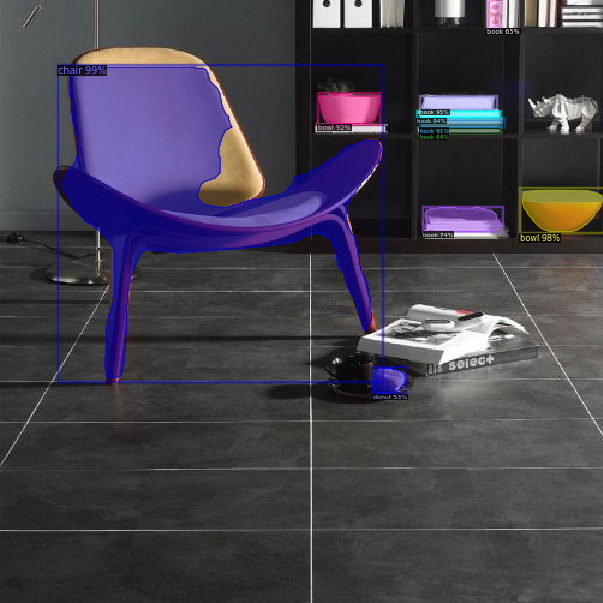

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}




IMAGE PATH:  1627046152156.49_00505/Colonia_Wood_Nordic_White_Oak_4436_4.jpg
ALT TEXT:  Polyflor Colonia 4436 Nordic White Oak
CONTEXT:  Polyflor Camaro Loc 3427 Grey Mountain Ash Click Vinyl Flooring From 25.95 m 2 Includes VAT & Free Delivery As low as 46.54 Quantity Discount Available From 23.50 m 2 Add to Cart Compare Polyflor Camaro Loc 3437 Smoked Limed Oak Click Vinyl Flooring From 25.95 m 2 Includes VAT & Free Delivery As low as 45.59 Quantity Discount Available From 23.50 m 2 Add to Cart Compare Polyflor Camaro Loc 3441 White Limed Oak Click Vinyl Flooring From 25.95 m 2 Includes VAT & Free Delivery As low as 46.54 Quantity Discount Available From 23.50 m 2 Add to Cart Compare Polyflor Camaro 2233 Smoked Brushed Elm Luxury Vinyl Flooring From 18.95 m 2 Includes VAT & Free Delivery As low as 60.08 Quantity Discount Available From 17.99 m 2 Add to Cart Compare Polyflor Camaro 2229 White Limed Oak Luxury Vinyl Flooring From 18.95 m 2 Includes VAT & Free Delivery As low as 60.08

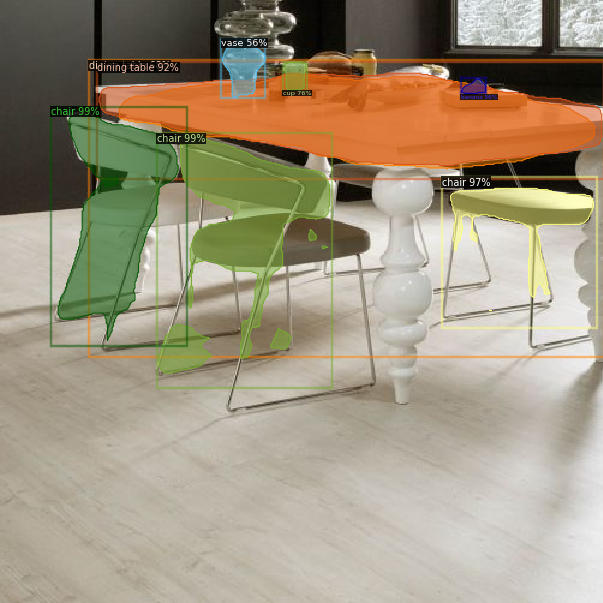

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}




IMAGE PATH:  1627046152156.49_00505/3439_hickory_oak.jpg
ALT TEXT:  Polyflor Camaro Loc 3439 Hickory Oak Click Vinyl Flooring
CONTEXT:  Polyflor Camaro 2252 Georgian Parquet Luxury Vinyl Flooring From 18.95 m 2 Includes VAT & Free Delivery As low as 60.08 Quantity Discount Available From 17.99 m 2 Add to Cart Compare Polyflor Camaro 2251 Cambridge Parquet Luxury Vinyl Flooring From 18.95 m 2 Includes VAT & Free Delivery As low as 60.08 Quantity Discount Available From 17.99 m 2 Add to Cart Compare Polyflor Camaro 2246 Quayside Oak Luxury Vinyl Flooring From 18.95 m 2 Includes VAT & Free Delivery As low as 60.08 Quantity Discount Available From 17.99 m 2 Add to Cart Compare Polyflor Camaro 2244 Cashmere Oak Luxury Vinyl Flooring From 18.95 m 2 Includes VAT & Free Delivery As low as 60.08 Quantity Discount Available From 17.99 m 2 Add to Cart Compare Polyflor Camaro 2249 Wild Amber Oak Luxury Vinyl Flooring From 18.95 m 2 Includes VAT & Free Delivery As low as 60.08 Quantity Discount A

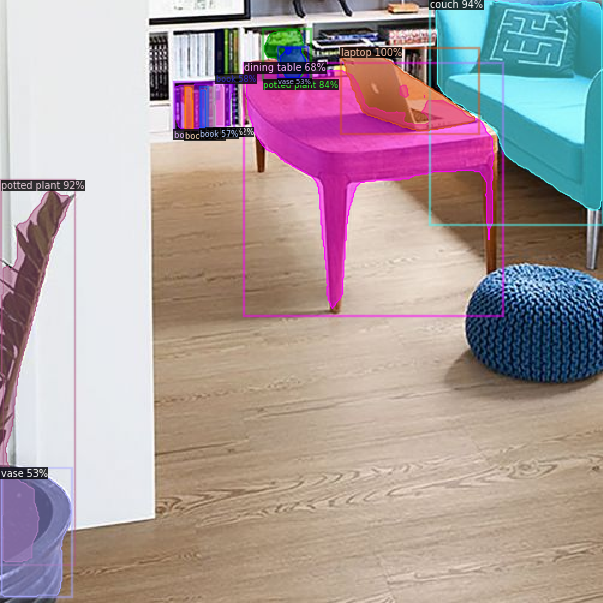

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}




IMAGE PATH:  1627046152156.49_00505/031669_675_01.jpg
ALT TEXT:  KI DITSY PRINT S/S K NIGHT
CONTEXT:  Australian Cotton Moon Short Sleeve Nightie $24.95 NEW + More Colours Australian Cotton Moon Short Sleeve Nightie $24.95 NEW + More Colours Leaf Print Short Sleeve Nightie $24.95 + More Colours Leaf Print Short Sleeve Nightie $24.95 + More Colours Star Print Long Sleeve Nightie $29.95 + More Colours Star Print Long Sleeve Nightie $29.95 + More Colours Heart Print Short Sleeve Nightie $24.95 + More Colours Heart Print Short Sleeve Nightie $24.95 + More Colours Heart Print Short Sleeve Nightie $24.95 + More Colours Wild Tulip Short Sleeve Nightie Special Price $19.95 Regular Price $24.95 Extra 50% Off At Checkout + More Colours Wild Tulip Short Sleeve Nightie Special Price $19.95 Regular Price $24.95 Extra 50% Off At Checkout + More Colours Lady Bug Short Sleeve Nightie Special Price $19.95 Regular Price $24.95 Extra 50% Off At Checkout + More Colours Lady Bug Short Sleeve Nightie Spec

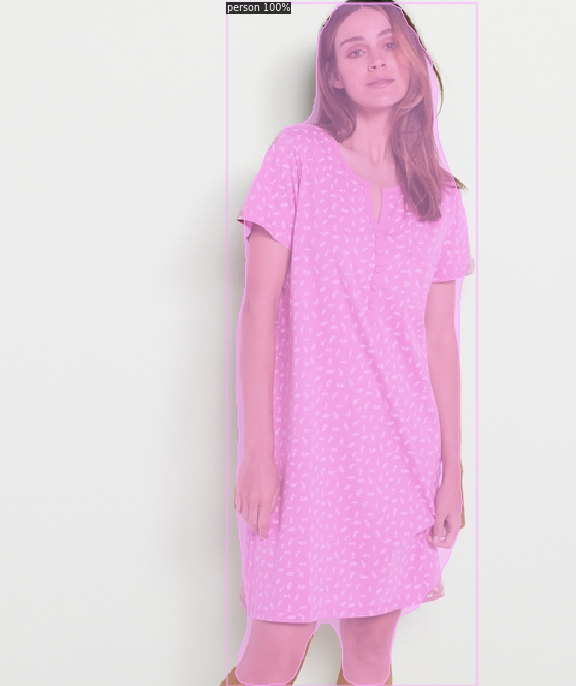

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}




IMAGE PATH:  1627046152156.49_00170/must-try-food-and-drink-destinations-outside-the-gta.jpg
ALT TEXT:  Must-Try Food and Drink Destinations Outside the GTA
CONTEXT:  Guides Must-Try Food and Drink Destinations Outside the GTA News Midori Ramen hosts night market-style grand opening this Saturday News Wallflower Doughnuts opens inside Tribeca Coffee in Oakville News Chef Jerome Robinson shares three favourite spots in new video series Hidden Gems News This new community-based caf becomes a trendy snack bar by night


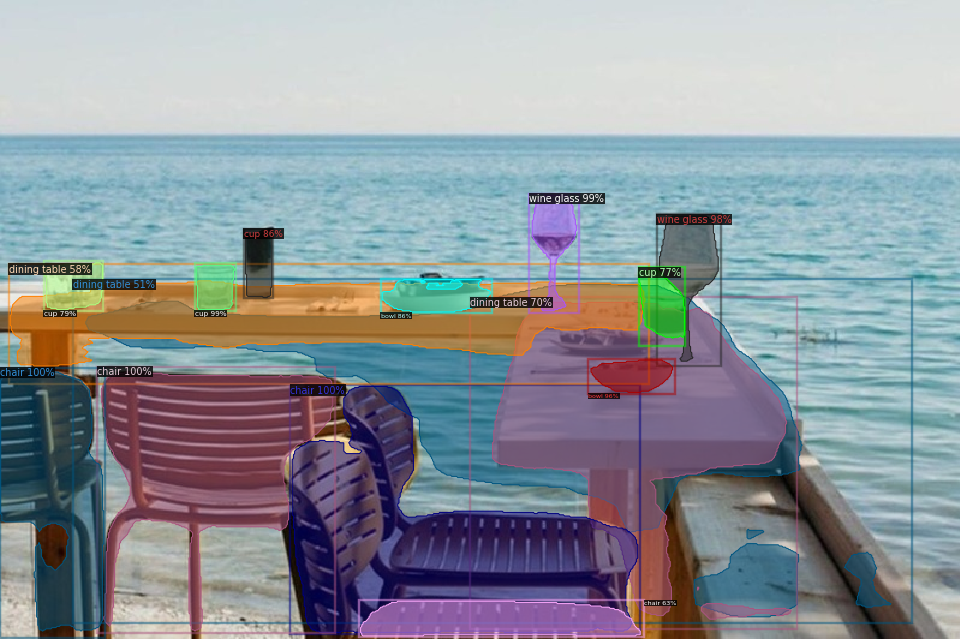

In [ ]:
for data_instance in image_path_list:
    im = cv2.imread(data_instance[0])
    cfg = get_cfg()
    # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    predictor = DefaultPredictor(cfg)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print('\n')
    print('IMAGE PATH: ', data_instance[0])
    print('ALT TEXT: ', data_instance[1])
    print('CONTEXT: ', data_instance[2])
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
#1627046152156.49_00348